# ML for TFLite

In [13]:
# $ pip uninstall -y tensorflow
# $ pip install -q tf-nightly
# $ pip install -q tensorflow-model-optimization

In [11]:
! pip install -q tensorflow-model-optimization

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_model_optimization as tfmot

In [3]:
classes_list = ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 
                'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 
                'kiwi', 'lemon', 'lettuce',  'mango', 'onion', 'orange',  'paprika', 
                'pear', 'peas', 'pineapple', 'pomegrante', 'potato', 'raddish', 'soy beans', 
                'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
len(classes_list)

36

In [4]:
batch_size = 32
#image_size = 256
target_size = (256,256)
input_shape = (256, 256, 3)

In [5]:
#Fetching train data and validation data and processing the data
train_datagen = ImageDataGenerator(rescale = 1.00 / 255.0)
val_datagen = ImageDataGenerator(rescale = 1.00 / 255.0)
test_datagen = ImageDataGenerator(rescale = 1.00 / 255.0)

train_dir = ''
test_dir = ''
val_dir = ''

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = target_size,
    batch_size = batch_size

)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = target_size,
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = target_size,
    batch_size = batch_size
)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


# Convert MobileNetV2

In [6]:
save_dir = ''
model = tf.keras.models.load_model(save_dir+'/modelMobileNetV2.h5')

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            loss="binary_crossentropy",
              metrics=['accuracy'])

q_aware_model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 256, 256, 3)  3          ['input_5[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapperV2  (None, 128, 128, 32  929        ['quantize_layer[0][0]']  

In [50]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
q_aware_model.fit(train_generator,
                  batch_size=batch_size,
                  epochs=25,
                  validation_data=validation_generator,
                  callbacks=[es])

Epoch 1/25
98/98 [==============================] - 451s 5s/step - loss: 0.2012 - accuracy: 0.0218 - val_loss: 0.2312 - val_accuracy: 0.0285
Epoch 2/25
98/98 [==============================] - 448s 5s/step - loss: 0.2709 - accuracy: 0.0218 - val_loss: 0.3138 - val_accuracy: 0.0285
Epoch 3/25
98/98 [==============================] - 448s 5s/step - loss: 0.3698 - accuracy: 0.0218 - val_loss: 0.4315 - val_accuracy: 0.0285
Epoch 4/25
98/98 [==============================] - 448s 5s/step - loss: 0.5047 - accuracy: 0.0218 - val_loss: 0.5844 - val_accuracy: 0.0285
Epoch 5/25
98/98 [==============================] - 446s 5s/step - loss: 0.7041 - accuracy: 0.0260 - val_loss: 0.8805 - val_accuracy: 0.0285
Epoch 6/25
98/98 [==============================] - 447s 5s/step - loss: 1.0492 - accuracy: 0.0295 - val_loss: 1.2336 - val_accuracy: 0.0285
Epoch 6: early stopping


In [52]:
_, baseline_model_accuracy = model.evaluate(test_generator, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(test_generator, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9749303460121155
Quant test accuracy: 0.027855154126882553


# Create Simple Model for Acc Test

In [40]:
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Dropout

# Define the simple model architecture.
simple_model = keras.Sequential([
  keras.layers.InputLayer(input_shape=input_shape),
  # keras.layers.Reshape(target_shape=target_size),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(36)
])


In [43]:
simple_model.compile(optimizer='adam',
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            loss = "binary_crossentropy",
              metrics=['accuracy'])

In [53]:
simple_model.fit(
  train_generator,
  epochs=25,
  validation_data=validation_generator,
  callbacks=[es]
)

Epoch 1/25
98/98 [==============================] - 141s 1s/step - loss: 1.2323 - accuracy: 0.0222 - val_loss: 1.2295 - val_accuracy: 0.0285
Epoch 2/25
98/98 [==============================] - 139s 1s/step - loss: 1.2323 - accuracy: 0.0222 - val_loss: 1.2295 - val_accuracy: 0.0285
Epoch 3/25
98/98 [==============================] - 139s 1s/step - loss: 1.2323 - accuracy: 0.0222 - val_loss: 1.2295 - val_accuracy: 0.0285
Epoch 4/25
98/98 [==============================] - 137s 1s/step - loss: 1.2323 - accuracy: 0.0222 - val_loss: 1.2295 - val_accuracy: 0.0285
Epoch 5/25
98/98 [==============================] - 141s 1s/step - loss: 1.2323 - accuracy: 0.0222 - val_loss: 1.2295 - val_accuracy: 0.0285
Epoch 6/25
98/98 [==============================] - 134s 1s/step - loss: 1.2323 - accuracy: 0.0222 - val_loss: 1.2295 - val_accuracy: 0.0285
Epoch 6: early stopping


In [54]:
_, simple_model_accuracy = simple_model.evaluate(test_generator, verbose=0)
print('Simple model test accuracy:', simple_model_accuracy)

Simple model test accuracy: 0.027855154126882553


# Test2

In [ ]:
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Dropout

model2=tf.keras.Sequential()

model2.add(layers.Conv2D(filters = 32, kernel_size=(3, 3),  padding = "same", activation='relu', input_shape=input_shape))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))

model2.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))

model2.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))

# model2.add(Dropout(0.5))
model2.add(layers.Dense(36, activation='softmax'))

model2.compile(optimizer= "adam",loss='categorical_crossentropy',metrics=['accuracy'])

history2 = model2.fit(
  train_generator,
  batch_size=batch_size,
  epochs=25,
  validation_data=validation_generator,
  callbacks=[es]
)

In [56]:
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Dropout

model2=tf.keras.Sequential()

model2.add(layers.Conv2D(filters = 32, kernel_size=(3, 3),  padding = "same", activation='relu', input_shape=input_shape))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))

model2.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))

model2.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))

# model2.add(Dropout(0.5))
model2.add(layers.Dense(36, activation='softmax'))

model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 flatten_10 (Flatten)        (None, 476288)          

In [57]:
model2.compile(optimizer= "adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [58]:
history2 = model2.fit(
  train_generator,
  batch_size=batch_size,
  epochs=25,
  validation_data=validation_generator,
  callbacks=[es]
)

Epoch 1/25
 4/98 [>.............................] - ETA: 3:37 - loss: 17.2786 - accuracy: 0.0312

c:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


98/98 [==============================] - 272s 3s/step - loss: 4.0684 - accuracy: 0.0504 - val_loss: 3.2544 - val_accuracy: 0.1168
Epoch 2/25
98/98 [==============================] - 271s 3s/step - loss: 3.1036 - accuracy: 0.1406 - val_loss: 2.2569 - val_accuracy: 0.4672
Epoch 3/25
98/98 [==============================] - 280s 3s/step - loss: 2.2253 - accuracy: 0.3942 - val_loss: 1.2042 - val_accuracy: 0.8433
Epoch 4/25
98/98 [==============================] - 277s 3s/step - loss: 0.8924 - accuracy: 0.7849 - val_loss: 0.5025 - val_accuracy: 0.9402
Epoch 5/25
98/98 [==============================] - 263s 3s/step - loss: 0.3420 - accuracy: 0.9425 - val_loss: 0.5010 - val_accuracy: 0.9430
Epoch 6/25
98/98 [==============================] - 262s 3s/step - loss: 0.1422 - accuracy: 0.9762 - val_loss: 0.3388 - val_accuracy: 0.9573
Epoch 7/25
98/98 [==============================] - 263s 3s/step - loss: 0.0951 - accuracy: 0.9888 - val_loss: 0.2739 - val_accuracy: 0.9630
Epoch 8/25
98/98 [======

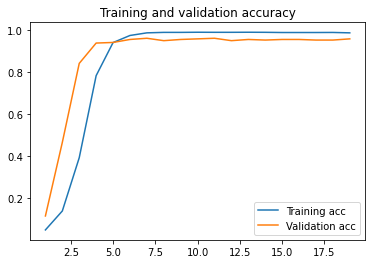

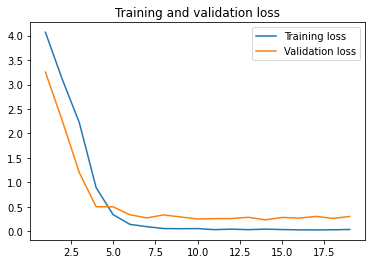

In [61]:
import matplotlib.pyplot as plt
# Plot the train results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [62]:
result = model2.evaluate(test_generator)

12/12 [==============================] - 24s 2s/step - loss: 0.2977 - accuracy: 0.9610


In [63]:
import tensorflow_model_optimization as tfmot

quantize_model2 = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model2 = quantize_model2(model2)

# `quantize_model` requires a recompile.
q_aware_model2.compile(optimizer='adam',
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            loss="categorical_crossentropy",
              metrics=['accuracy'])

q_aware_model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_3 (QuantizeL  (None, 256, 256, 3)      3         
 ayer)                                                           
                                                                 
 quant_conv2d_10 (QuantizeWr  (None, 256, 256, 32)     963       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_10 (Qua  (None, 128, 128, 32)     1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_conv2d_11 (QuantizeWr  (None, 126, 126, 64)     18627     
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_11 (Qua  (None, 63, 63, 64)     

In [64]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
q_aware_model2.fit(train_generator,
                  batch_size=batch_size,
                  epochs=1,
                  validation_data=validation_generator,
                  callbacks=[es])

c:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


98/98 [==============================] - 362s 4s/step - loss: 0.0978 - accuracy: 0.9795 - val_loss: 0.2349 - val_accuracy: 0.9573


In [65]:
_, baseline_model_accuracy2 = model2.evaluate(test_generator, verbose=0)

_, q_aware_model_accuracy2 = q_aware_model2.evaluate(test_generator, verbose=0)

print('new model2 test accuracy:', baseline_model_accuracy2)
print('Quant test accuracy:', q_aware_model_accuracy2)

new model2 test accuracy: 0.961002767086029
Quant test accuracy: 0.9582172632217407


In [66]:
save_dir = ''
q_aware_model2.save(save_dir+'/q_model2.h5')

In [67]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model2)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\YOUNGH~1\AppData\Local\Temp\tmpx9ftx56d\assets


INFO:tensorflow:Assets written to: C:\Users\YOUNGH~1\AppData\Local\Temp\tmpx9ftx56d\assets
c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [68]:
# Save the model.
with open('q_model2.tflite', 'wb') as f:
  f.write(quantized_tflite_model)